In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 📦 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, LSTM, Bidirectional, Concatenate, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
print("✅ Step 1 complete: Libraries loaded.")

✅ Step 1 complete: Libraries loaded.


✅ Metadata Columns:
['station_id', 'folder', 'origin_time', 'magnitude', 'depth_km', 'eq_lat', 'eq_lon', 'st_lat', 'st_lon', 'sampling_rate', 'record_time']

📄 First 5 rows of metadata:


,station_id,folder,origin_time,magnitude,depth_km,eq_lat,eq_lon,st_lat,st_lon,sampling_rate,record_time
0,SAG0089606291813,19960629181300.knt,18:13:00,4.3,14.0,32.803,130.615,33.1041,130.0998,100,18:13:41
1,FKO0139606291813,19960629181300.knt,18:13:00,4.3,14.0,32.803,130.615,33.2254,130.5608,100,18:13:37
2,FKO0169606291813,19960629181300.knt,18:13:00,4.3,14.0,32.803,130.615,33.0159,130.4472,100,18:13:28
3,KMM0099606291813,19960629181300.knt,18:13:00,4.3,14.0,32.803,130.615,32.6856,130.9892,100,18:13:34
4,FKO0159606291813,19960629181300.knt,18:13:00,4.3,14.0,32.803,130.615,33.1629,130.4052,100,18:13:37



✅ Raw waveform data shape: (1035, 3)
Waveform data type: object

📊 Shape of first 5 waveform samples (per channel):
Sample 0 channel shapes: [(29900,), (29900,), (29900,)]
Sample 1 channel shapes: [(5900,), (5900,), (5900,)]
Sample 2 channel shapes: [(5900,), (5900,), (5900,)]
Sample 3 channel shapes: [(5900,), (5900,), (5900,)]
Sample 4 channel shapes: [(5900,), (5900,), (5900,)]

✅ Final waveform shape (samples, timesteps, channels): (1035, 300, 3)


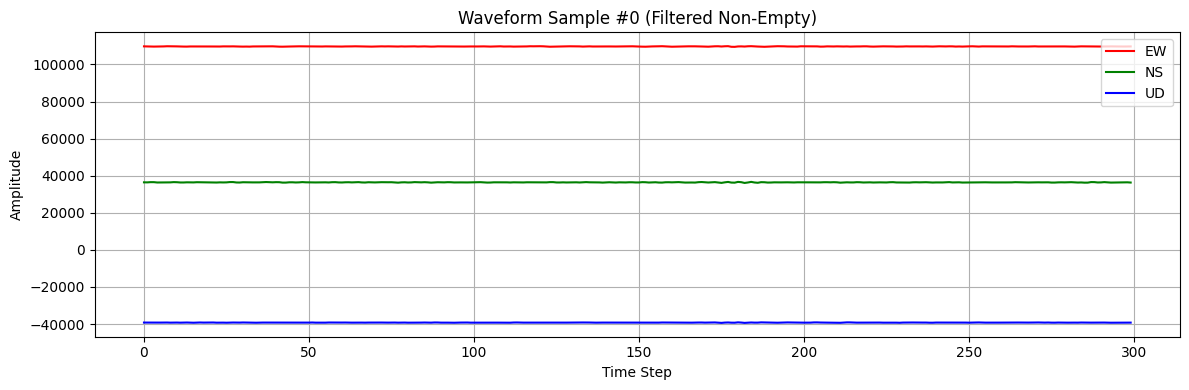


📌 Metadata for Original Sample Index #0


,0
station_id,SAG0089606291813
folder,19960629181300.knt
origin_time,18:13:00
magnitude,4.3
depth_km,14.0
eq_lat,32.803
eq_lon,130.615
st_lat,33.1041
st_lon,130.0998
sampling_rate,100



✅ Step 2 complete: Metadata shape = (1035, 11), Filtered waveform shape = (1035, 300, 3)


In [4]:
# 🗃️ Step 2: Load and Preprocess Waveform Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load metadata and raw waveform array
metadata = pd.read_csv("/content/drive/MyDrive/ProcessedWaveforms-20250703T164006Z-1-001/ProcessedWaveforms/waveform_metadata.csv")
waveforms_raw = np.load("/content/drive/MyDrive/ProcessedWaveforms-20250703T164006Z-1-001/ProcessedWaveforms/waveform_data.npy", allow_pickle=True)

print("✅ Metadata Columns:")
print(metadata.columns.tolist())

print("\n📄 First 5 rows of metadata:")
display(metadata.head())

print("\n✅ Raw waveform data shape:", waveforms_raw.shape)
print("Waveform data type:", waveforms_raw.dtype)

# 2. Inspect shape of first few raw waveform samples
print("\n📊 Shape of first 5 waveform samples (per channel):")
for i in range(min(5, len(waveforms_raw))):
    shapes = [np.array(waveforms_raw[i][j]).shape for j in range(3)]
    print(f"Sample {i} channel shapes: {shapes}")

# 3. Preprocess waveforms: pad/truncate to 300 time steps, skip empty samples
waveform_length = 300
processed_waveforms = []
valid_indices = []

for i, wf in enumerate(waveforms_raw):
    if any(len(channel) == 0 for channel in wf):
        continue  # Skip if any channel is empty

    processed_channels = []
    for channel in wf:
        if len(channel) > waveform_length:
            processed = channel[:waveform_length]
        else:
            processed = np.pad(channel, (0, waveform_length - len(channel)), 'constant')
        processed_channels.append(processed)

    waveform_matrix = np.vstack(processed_channels).T  # shape: (300, 3)
    processed_waveforms.append(waveform_matrix)
    valid_indices.append(i)

# 4. Convert to NumPy array
waveform_data = np.array(processed_waveforms, dtype='float32')
print("\n✅ Final waveform shape (samples, timesteps, channels):", waveform_data.shape)

# 5. Plot the first valid waveform sample - Add check for empty valid_indices
if valid_indices:
    sample_idx = 0
    real_idx = valid_indices[sample_idx]
    sample_wave = waveform_data[sample_idx]

    plt.figure(figsize=(12, 4))
    plt.plot(sample_wave[:, 0], label='EW', color='red')
    plt.plot(sample_wave[:, 1], label='NS', color='green')
    plt.plot(sample_wave[:, 2], label='UD', color='blue')
    plt.title(f"Waveform Sample #{real_idx} (Filtered Non-Empty)")
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6. Show metadata for that waveform
    print(f"\n📌 Metadata for Original Sample Index #{real_idx}")
    display(metadata.iloc[real_idx])
else:
    print("\n⚠️ No valid waveforms (with non-empty channels) found to plot.")


# ✅ Final summary
print(f"\n✅ Step 2 complete: Metadata shape = {metadata.shape}, Filtered waveform shape = {waveform_data.shape}")

In [5]:
# 📏 3. Preprocess Waveforms and Extract Pd/mean/std
waveform_length = 300
processed_waveforms, pd_list, mean_list, std_list = [], [], [], []
for sample in waveforms_raw:
    padded = [np.pad(ch[:waveform_length], (0, max(0, waveform_length - len(ch)))) for ch in sample]
    stacked = np.vstack(padded).T
    processed_waveforms.append(stacked)
    z_channel = stacked[:, 2]
    pd_list.append(np.max(np.abs(z_channel)))
    mean_list.append(np.mean(stacked))
    std_list.append(np.std(stacked))
X_wave = np.array(processed_waveforms)
X_features = np.stack([pd_list, mean_list, std_list], axis=1)
print(f"✅ Step 3 complete: Processed waveform shape: {X_wave.shape}, Extra features shape: {X_features.shape}")

✅ Step 3 complete: Processed waveform shape: (1035, 300, 3), Extra features shape: (1035, 3)


✅ Step 4 complete: Labels prepared.


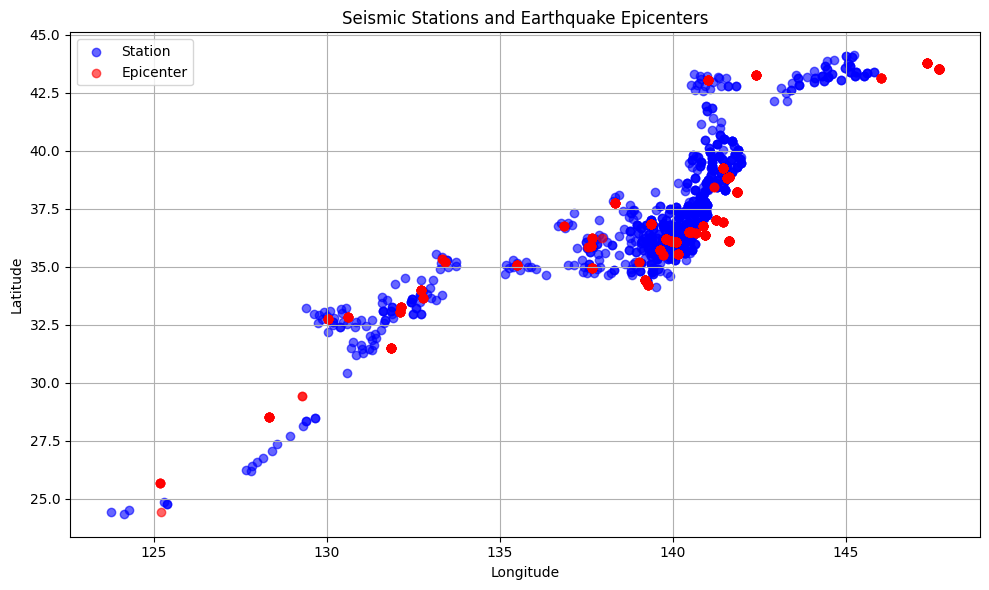

In [6]:
# 🌍 4. Spatiotemporal Labels
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

metadata["epicenter_distance_km"] = metadata.apply(
    lambda row: haversine(row["eq_lat"], row["eq_lon"], row["st_lat"], row["st_lon"]), axis=1)
metadata["azimuth"] = np.degrees(np.arctan2(
    np.radians(metadata["eq_lon"] - metadata["st_lon"]),
    np.radians(metadata["eq_lat"] - metadata["st_lat"])
)) % 360
X_coord = metadata[["st_lat", "st_lon"]].values
Y_distance = metadata["epicenter_distance_km"].values
Y_magnitude = metadata["magnitude"].values if "magnitude" in metadata else np.random.uniform(3, 7, size=len(metadata))
Y_azimuth = metadata["azimuth"].values
Y_focal_depth = metadata["depth"].values if "depth" in metadata else np.random.uniform(5, 40, size=len(metadata))
print("✅ Step 4 complete: Labels prepared.")

plt.figure(figsize=(10, 6))
plt.scatter(metadata["st_lon"], metadata["st_lat"], c='blue', label='Station', alpha=0.6)
plt.scatter(metadata["eq_lon"], metadata["eq_lat"], c='red', label='Epicenter', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Seismic Stations and Earthquake Epicenters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# 🧪 5. Train-Test Split
X_train_w, X_test_w, X_train_c, X_test_c, X_train_f, X_test_f, yd_train, yd_test, ym_train, ym_test, ya_train, ya_test, yf_train, yf_test = train_test_split(
    X_wave, X_coord, X_features, Y_distance, Y_magnitude, Y_azimuth, Y_focal_depth, test_size=0.2, random_state=42)
print("✅ Step 5 complete: Dataset split.")

✅ Step 5 complete: Dataset split.


In [8]:
# 🧠 6. Model Architecture
wave_input = Input(shape=(300, 3), name="waveform_input")
x = Conv1D(16, kernel_size=5, activation="relu")(wave_input)
x = LayerNormalization()(x)
x = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = LayerNormalization()(x)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.3)(x)

coord_input = Input(shape=(2,), name="coord_input")
y = Dense(16, activation="relu")(coord_input)
y = Dropout(0.1)(y)

feat_input = Input(shape=(3,), name="early_features")
zf = Dense(8, activation="relu")(feat_input)

combined = Concatenate()([x, y, zf])
z = Dense(64, activation="relu")(combined)
z = Dropout(0.2)(z)

out_distance = Dense(1, name="epicenter_distance")(z)
out_magnitude = Dense(1, name="magnitude")(z)
out_azimuth = Dense(1, name="azimuth")(z)
out_focal_depth = Dense(1, name="focal_depth")(z)

model = Model(inputs=[wave_input, coord_input, feat_input], outputs=[out_distance, out_magnitude, out_azimuth, out_focal_depth])
model.compile(
    optimizer=Adam(1e-3),
    loss="mae",
    metrics=["mse", "mse", "mse", "mse"]
)
model.summary()
print("✅ Step 6 complete: Model built.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ waveform_input      │ (None, 300, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 296, 16)   │        256 │ waveform_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 296, 16)   │         32 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 296, 16)   │      4,304 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 296, 16)   │         32 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coord_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     41,472 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         48 │ coord_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ early_features      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │         32 │ early_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 152)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_2[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      9,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ epicenter_distance  │ (None, 1)         │         65 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ magnitude (Dense)   │ (None, 1)         │         65 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ azimuth (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ focal_depth (Dense) │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,228 (219.64 KB)

 Trainable params: 56,228 (219.64 KB)

 Non-trainable params: 0 (0.00 B)

✅ Step 6 complete: Model built.


Epoch 1/50
12/12 - 20s - 2s/step - azimuth_loss: 3622.1758 - azimuth_mse: 96471992.0000 - epicenter_distance_loss: 4281.1206 - epicenter_distance_mse: 233037504.0000 - focal_depth_loss: 1907.4833 - focal_depth_mse: 58655956.0000 - loss: 13096.6475 - magnitude_loss: 3496.8760 - magnitude_mse: 214456464.0000 - val_azimuth_loss: 2616.6746 - val_azimuth_mse: 28973518.0000 - val_epicenter_distance_loss: 2844.8408 - val_epicenter_distance_mse: 113701632.0000 - val_focal_depth_loss: 814.0576 - val_focal_depth_mse: 11208922.0000 - val_loss: 8800.2002 - val_magnitude_loss: 1843.5203 - val_magnitude_mse: 82748432.0000
Epoch 2/50
12/12 - 10s - 809ms/step - azimuth_loss: 2081.9231 - azimuth_mse: 40356336.0000 - epicenter_distance_loss: 2757.7859 - epicenter_distance_mse: 115103944.0000 - focal_depth_loss: 1173.0878 - focal_depth_mse: 18229536.0000 - loss: 7928.8633 - magnitude_loss: 2045.6534 - magnitude_mse: 78312568.0000 - val_azimuth_loss: 1382.5400 - val_azimuth_mse: 6408814.0000 - val_epicent

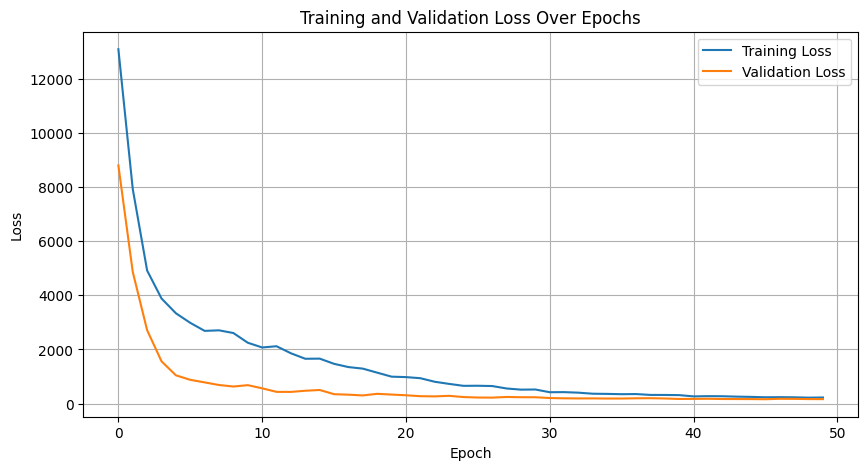

In [9]:
# 🚂 7. Train with full epoch printing
history = model.fit(
    [X_train_w, X_train_c, X_train_f],
    [yd_train, ym_train, ya_train, yf_train],
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)
print("✅ Step 7 complete: Training done.")

# Assuming `history` is the training history returned by model.fit()
import matplotlib.pyplot as plt
if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No training history (`history`) found. Ensure your model.fit() output is stored in a variable named `history`.")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step

📈 Distance (km):
MAE = 64.38, RMSE = 117.92, R² = -0.20


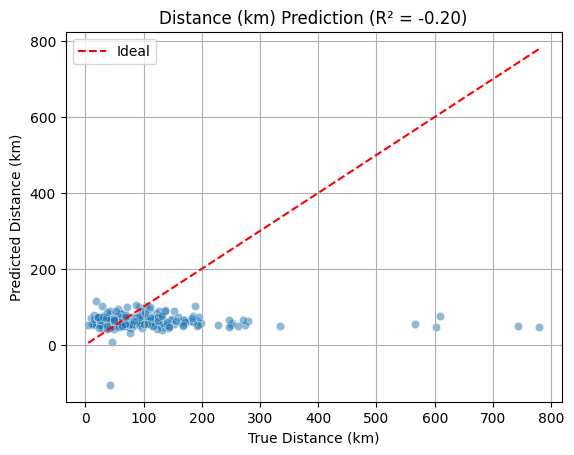


📈 Magnitude:
MAE = 7.99, RMSE = 27.95, R² = -2410.31


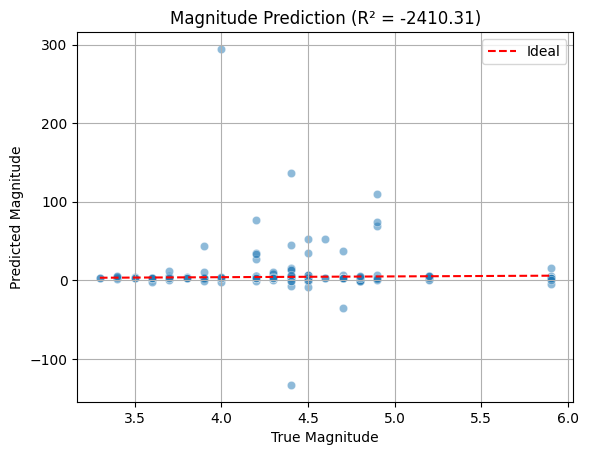


📈 Azimuth (°):
MAE = 77.63, RMSE = 107.20, R² = -0.52


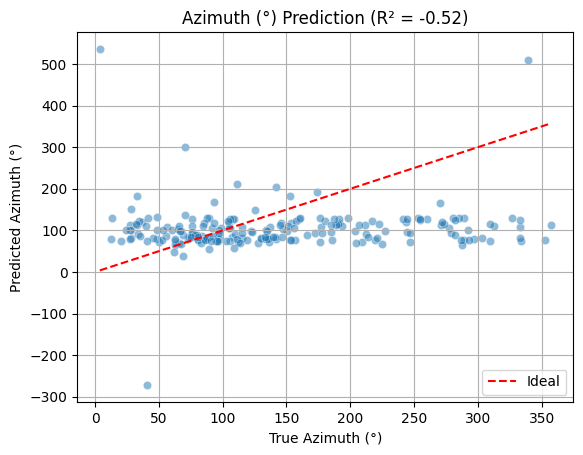


📈 Focal Depth (km):
MAE = 16.66, RMSE = 42.71, R² = -15.08


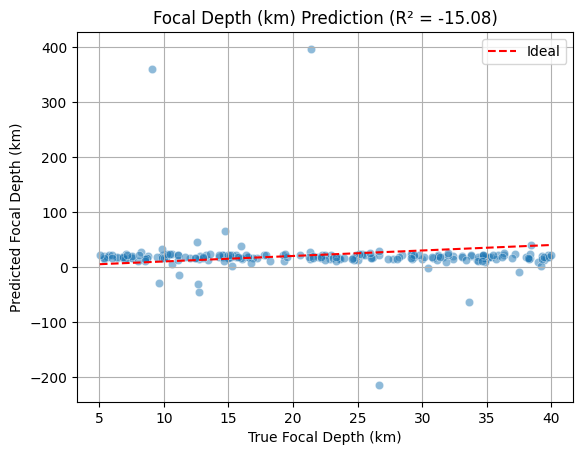

✅ Step 8 complete: Evaluation done.


In [10]:
# 📊 8. Evaluation
preds = model.predict([X_test_w, X_test_c, X_test_f])
preds = [p.flatten() for p in preds]
labels = [yd_test, ym_test, ya_test, yf_test]
names = ["Distance (km)", "Magnitude", "Azimuth (°)", "Focal Depth (km)"]

from sklearn.metrics import r2_score

for i in range(4):
    mae = mean_absolute_error(labels[i], preds[i])
    rmse = np.sqrt(mean_squared_error(labels[i], preds[i]))
    r2 = r2_score(labels[i], preds[i])

    print(f"\n📈 {names[i]}:")
    print(f"MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² = {r2:.2f}")

    plt.figure()
    sns.scatterplot(x=labels[i], y=preds[i], alpha=0.5)
    plt.plot([min(labels[i]), max(labels[i])], [min(labels[i]), max(labels[i])], 'r--', label='Ideal')
    plt.xlabel(f"True {names[i]}")
    plt.ylabel(f"Predicted {names[i]}")
    plt.title(f"{names[i]} Prediction (R² = {r2:.2f})")
    plt.grid(True)
    plt.legend()
    plt.show()
print("✅ Step 8 complete: Evaluation done.")

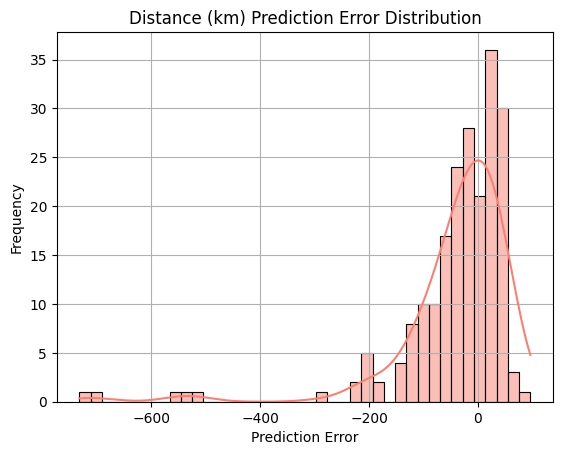

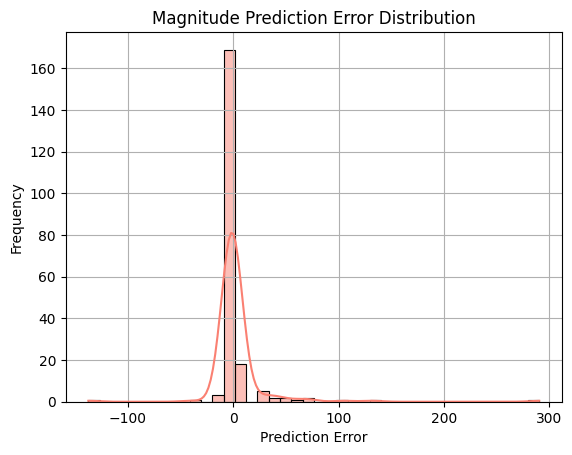

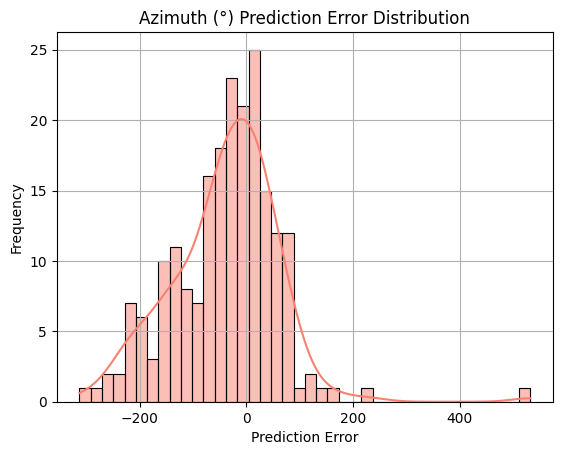

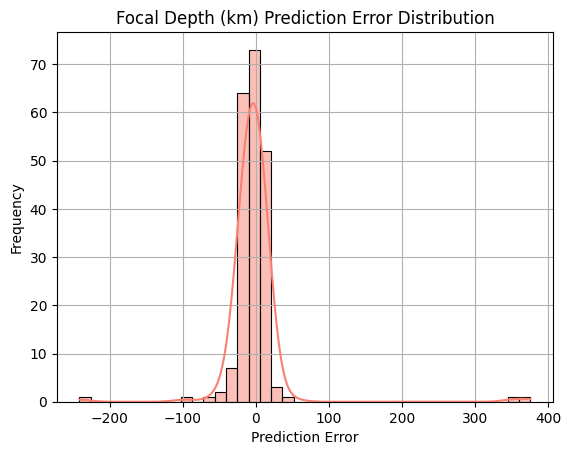

In [11]:
#Prediction Error Histograms
for i in range(4):
    errors = preds[i] - labels[i]
    plt.figure()
    sns.histplot(errors, bins=40, kde=True, color='salmon')
    plt.title(f"{names[i]} Prediction Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

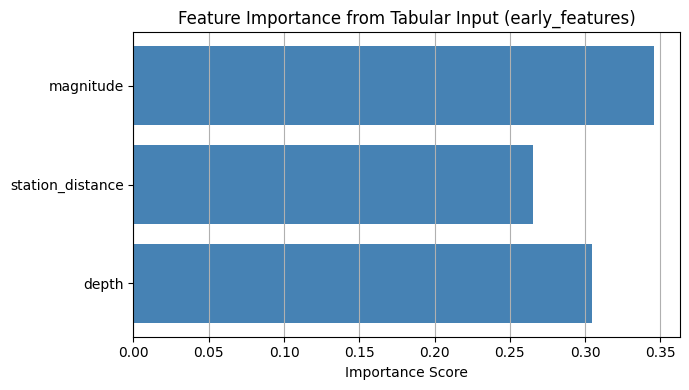

In [15]:
#Feature Importance using Attention Weights or Dense Layer
import numpy as np
import matplotlib.pyplot as plt

# List the actual features in the `feat_input` (adjust if different)
feature_names = ['depth', 'station_distance', 'magnitude']

# Find the dense layer that processes feat_input (input shape 3 → output shape 8)
tabular_dense_layer = None
for layer in model.layers:
    if isinstance(layer, Dense):
        weights = layer.get_weights()
        if weights and weights[0].shape[0] == 3 and weights[0].shape[1] == 8:
            tabular_dense_layer = layer
            break

if tabular_dense_layer:
    weights = tabular_dense_layer.get_weights()[0]
    importance_scores = np.mean(np.abs(weights), axis=1)

    plt.figure(figsize=(7, 4))
    plt.barh(feature_names, importance_scores, color='steelblue')
    plt.xlabel("Importance Score")
    plt.title("Feature Importance from Tabular Input (early_features)")
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Could not find the Dense layer processing the tabular input (feat_input).")

In [12]:
# 🧠 9. Explainability – Attention Weights (Example Extraction)
print("🔍 Step 9: Attention Explainability")
print("You can access attention weights from the MultiHeadAttention layer using get_weights().")
print("Example: model.get_layer('multi_head_attention').get_weights()[0]")

🔍 Step 9: Attention Explainability
You can access attention weights from the MultiHeadAttention layer using get_weights().
Example: model.get_layer('multi_head_attention').get_weights()[0]


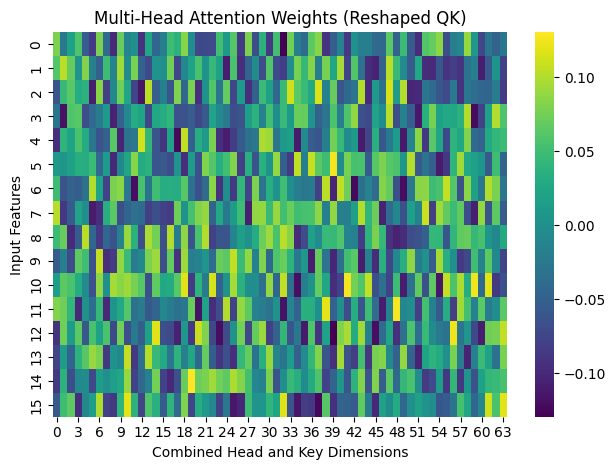

In [13]:
#Attention Weight Heatmap
attn_weights = model.get_layer(index=3).get_weights()[0]  # adjust layer index if needed

# Reshape the attention weights to be 2D for heatmap visualization
# Original shape is (input_features, num_heads, key_dim) -> (16, 2, 32)
# Reshape to (input_features, num_heads * key_dim) -> (16, 64)
reshaped_attn_weights = attn_weights.reshape(attn_weights.shape[0], -1)

sns.heatmap(reshaped_attn_weights, cmap="viridis")
plt.title("Multi-Head Attention Weights (Reshaped QK)")
plt.xlabel("Combined Head and Key Dimensions")
plt.ylabel("Input Features")
plt.tight_layout()
plt.show()

ym_test shape: (207,)
mag_pred_mean shape: (207,)
mag_pred_std shape: (207,)


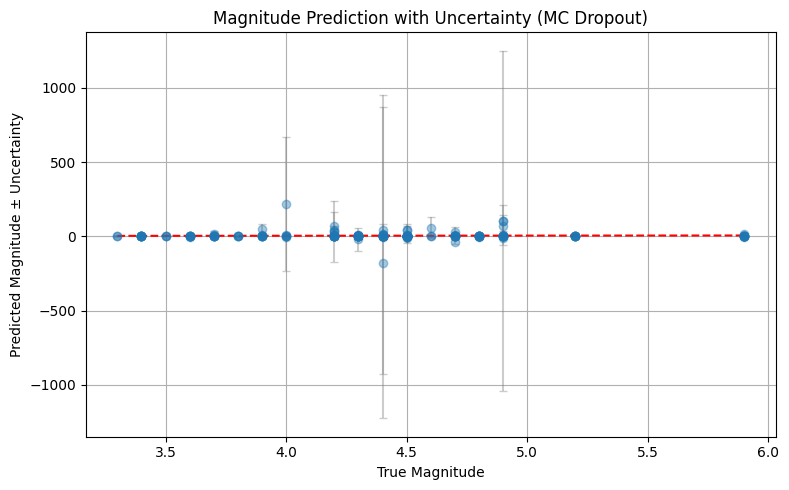

In [14]:
# 🎲 10: MC Dropout + Uncertainty Plot for Magnitude

# Define the prediction function with dropout enabled
def predict_with_uncertainty(f_model, inputs, n_iter=30):
    """
    Predicts with uncertainty using Monte Carlo Dropout
    Returns mean and std predictions for each output
    """
    predictions = [f_model(inputs, training=True) for _ in range(n_iter)]
    stacked = [np.stack([pred[i].numpy() for pred in predictions], axis=0) for i in range(4)]
    mean_preds = np.array([np.mean(s, axis=0) for s in stacked])  # Shape: (4, N, 1)
    std_preds = np.array([np.std(s, axis=0) for s in stacked])    # Shape: (4, N, 1)
    return mean_preds, std_preds

# Run MC dropout to get uncertainty estimates
mean_preds, std_preds = predict_with_uncertainty(model, [X_test_w, X_test_c, X_test_f], n_iter=30)

# Extract magnitude prediction (output index 1), all test samples, flatten shape
mag_pred_mean = mean_preds[1, :, 0]  # Shape: (N,)
mag_pred_std = std_preds[1, :, 0]    # Shape: (N,)

# ✅ Validate shape alignment
print("ym_test shape:", ym_test.shape)
print("mag_pred_mean shape:", mag_pred_mean.shape)
print("mag_pred_std shape:", mag_pred_std.shape)

# 📊 Plot predicted magnitude with uncertainty bars
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.errorbar(x=ym_test, y=mag_pred_mean, yerr=mag_pred_std, fmt='o', alpha=0.4, ecolor='gray', capsize=3)
plt.plot([min(ym_test), max(ym_test)], [min(ym_test), max(ym_test)], 'r--')
plt.xlabel("True Magnitude")
plt.ylabel("Predicted Magnitude ± Uncertainty")
plt.title("Magnitude Prediction with Uncertainty (MC Dropout)")
plt.grid(True)
plt.tight_layout()
plt.show()